In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from asteria.stellardist import StellarDensity
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize

In [2]:
def diff(x, r):
    diff = np.abs(Dist2Rate(x) - r)
    return float(diff)

def Dist2Rate(d):
    return sd_ccsn_rate(d)

def Rate2Dist(r_in):
    if not isinstance(r_in, np.ndarray):
        if r_in > sd_ccsn_tot_rate:
            r_in = sd_ccsn_tot_rate
        res = minimize(diff, x0=10, args=r_in)
        return res.x
    else:
        np.where(r_in>sd_ccsn_tot_rate,sd_ccsn_tot_rate,r_in)
        r_out = []
        for rr in r_in:
            res = minimize(diff, x0=10, args=rr)
            r_out.append(res.x)
        r_out = np.array(r_out)
        return r_out
    
def diff_cdf(x, cdf_val):
    if x > 25 + 1E-3: #everything above 25 kpc has a probability of 100%, but we want the 'edge' so we punish any
        # value that is higher than 25 kpc + epsilon, epsilon << 1
        return 1E6
    else:
        diff = np.abs(sd_cdf(x) - cdf_val)
        return float(diff)
    
def inv_cdf(cdf_val):
    if not isinstance(cdf_val, np.ndarray):
        res = minimize(diff_cdf, x0 = 5, args=cv)
        return res.x
    else:
        d = []
        for cv in cdf_val:
            loss, i = 1, 0
            x0s = np.array([5,10,15,20])
            while loss > 1E-3:
                res = minimize(diff_cdf, x0 = x0s[i], args=cv)
                loss = res.fun
                i += 1
                if i > 3:
                    print('Fit failed to converge!')
                    break
            d.append(res.x)
        d = np.array(d)
        return d
    
def MSE(v):
    return np.sqrt(np.sum((func(v)-sig)**2))

In [3]:
stime = "wide" # "wide", "narrow"
sfreq = 0 * u.Hz # freq. modulation: 0 Hz, +- 10 Hz

smix = "NoTransformation" # "NoTransformation", "CompleteExchange", "AdiabaticMSW"
shier = "normal" # "normal", "inverted"
smodel = "Tamborra_2014_20M" # "Tamborra_2014_20M", "Tamborra_2014_27M"
sdir = 1

temp_freq = 80 * u.Hz + sfreq  
temp_periods = 8
temp_amplitude = 1

filename1 = './files/temp_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time_'+stime+'_template_{:.0f}Hz_{}periods_{}scaling'.format(temp_freq.value, temp_periods, temp_amplitude)+'_IC86+Gen2.pkl'
filename2 = './files/temp_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time_'+stime+'_template_{:.0f}Hz_{}periods_{}scaling'.format(temp_freq.value, temp_periods, temp_amplitude)+'_IC86+Gen2+WLS.pkl'

file1 = open(filename1, 'rb')
data1 = pickle.load(file1)
file2 = open(filename2, 'rb')
data2 = pickle.load(file2)

distances1, Sts1_gen2, Sts1_ic86, Bts1_gen2, Bts1_ic86, Z1_gen2, Z1_ic86 = data1
distances2, Sts2_gen2, Sts2_ic86, Bts2_gen2, Bts2_ic86, Z2_gen2, Z2_ic86 = data2

In [4]:
# stellar distribution file, Adams 2013 model, returns CDF
sd = StellarDensity('../../../../data/stellar/sn_radial_distrib_adams.fits', add_LMC=False, add_SMC=False)

dmax = np.max((distances1,distances2))*u.kpc
sd_cdf = PchipInterpolator(sd.dist.value, sd.cdf)

In [5]:
#interpolations of the significance data
d = 8 * u.kpc
sig_wls_50 = PchipInterpolator(distances1[distances1>d], Z2_gen2[distances1>d].T[0])
sig_gen2_50 = PchipInterpolator(distances1[distances1>d], Z1_gen2[distances1>d].T[0])
sig_ic86_50 = PchipInterpolator(distances1[distances1>d], Z1_ic86[distances1>d].T[0])

sig_wls_14 = PchipInterpolator(distances1[distances1>d], Z2_gen2[distances1>d].T[1])
sig_gen2_14 = PchipInterpolator(distances1[distances1>d], Z1_gen2[distances1>d].T[1])
sig_ic86_14 = PchipInterpolator(distances1[distances1>d], Z1_ic86[distances1>d].T[1])

sig_wls_86 = PchipInterpolator(distances1[distances1>d], Z2_gen2[distances1>d].T[2])
sig_gen2_86 = PchipInterpolator(distances1[distances1>d], Z1_gen2[distances1>d].T[2])
sig_ic86_86 = PchipInterpolator(distances1[distances1>d], Z1_ic86[distances1>d].T[2])

sd_ccsn = PchipInterpolator(sd.dist.value, sd.cdf)

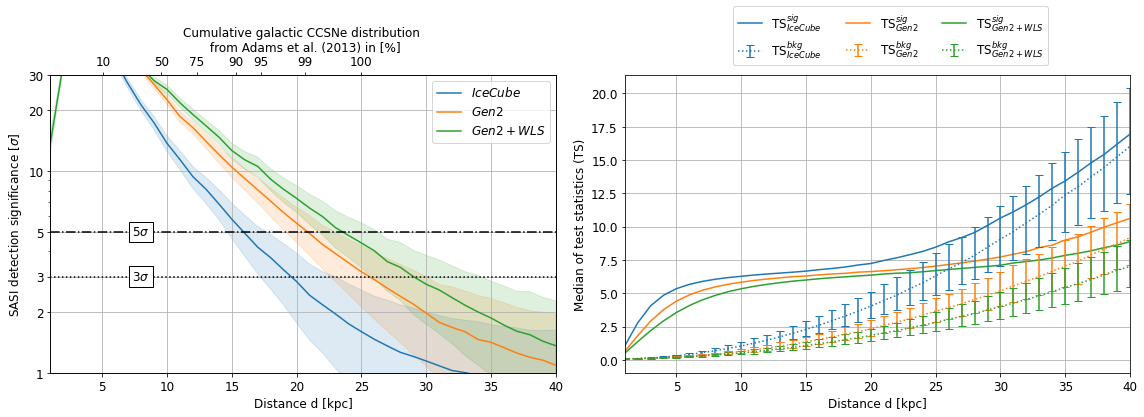

In [6]:
fig, ax = plt.subplots(1,2, figsize = (16,6))
ax = ax.ravel()

ax[0].plot(distances1, Z1_ic86.T[0], color = 'C0', label=r'$IceCube$')
ax[0].plot(distances1, Z1_gen2.T[0], color = 'C1', label=r'$Gen2$')
ax[0].plot(distances1, Z2_gen2.T[0], color = 'C2', label=r'$Gen2+WLS$')

ax[0].fill_between(distances1.value, Z1_ic86.T[2], Z1_ic86.T[1], alpha = 0.15, color = 'C0')
ax[0].fill_between(distances1.value, Z1_gen2.T[2], Z1_gen2.T[1], alpha = 0.15, color = 'C1')
ax[0].fill_between(distances1.value, Z2_gen2.T[2], Z2_gen2.T[1], alpha = 0.15, color = 'C2')

ax[0].set_xlabel('Distance d [kpc]', fontsize = 12)
ax[0].set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 12)
ax[0].set_xlim((1,40))
ax[0].set_ylim((1,30))

ax[0].tick_params(labelsize = 12)

ax[0].set_yscale('log')
ax[0].set_yticks([1,2,3,5,10,20,30])
ax[0].set_yticklabels(['1','2','3','5','10','20','30'])

ax[0].grid()
ax[0].legend(loc='upper right', fontsize = 12)

ax[0].axhline(3, color='k', ls = ':')
ax[0].axhline(5, color='k', ls = '-.')
ax[0].text(8, 3, r"3$\sigma$", size=12,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax[0].text(8, 5, r"5$\sigma$", size=12,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax[0].twiny()
ax22.set_xlim(ax[0].get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 12)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 12)

#signal without errorbar
ax[1].plot(distances1, Sts1_ic86.T[0], color = 'C0', label=r'TS$^{sig}_{IceCube}$')
ax[1].plot(distances1, Sts1_gen2.T[0], color = 'C1', label=r'TS$^{sig}_{Gen2}$')
ax[1].plot(distances2, Sts2_gen2.T[0], color = 'C2', label=r'TS$^{sig}_{Gen2+WLS}$')

#background with errorbar
ax[1].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label=r'TS$^{bkg}_{IceCube}$')
ax[1].errorbar(x=distances1, y=Bts1_gen2.T[0],yerr=(Bts1_gen2.T[0]-Bts1_gen2.T[1],Bts1_gen2.T[2]-Bts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = ':', label=r'TS$^{bkg}_{Gen2}$')
ax[1].errorbar(x=distances2, y=Bts2_gen2.T[0],yerr=(Bts2_gen2.T[0]-Bts2_gen2.T[1],Bts2_gen2.T[2]-Bts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = ':', label=r'TS$^{bkg}_{Gen2+WLS}$')

#rearrange legend handels
handles,labels = ax[1].get_legend_handles_labels()

handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]


ax[1].set_xlabel('Distance d [kpc]', fontsize = 12)
ax[1].set_ylabel('Median of test statistics (TS)', fontsize = 12)
ax[1].set_xlim((1,40))
#ax[1].set_yscale('log')
ax[1].tick_params(labelsize = 12)
ax[1].legend(handles, labels, ncol = 3, fontsize = 12, bbox_to_anchor=(0.85, 1.25))
ax[1].grid()

plt.tight_layout()

filename = './plots/temp_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time_'+stime+'_template_{:.0f}Hz_{}periods_{}scaling'.format(temp_freq.value, temp_periods, temp_amplitude)+'_IC86+Gen2+WLS.png'
plt.savefig(filename, dpi = 200, facecolor = 'white')

In [ ]:
#write results into txt file

filename = './logs/temp_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time_'+stime+'_template_{:.0f}Hz_{}periods_{}scaling'.format(temp_freq.value, temp_periods, temp_amplitude)+'_IC86+Gen2+WLS.txt'
with open(filename, 'a') as f:
    for sig in [3,5]:
        print("{} sigma detection level".format(sig), file=f)
        for det in ["wls", "gen2", "ic86"]:
            print(det, file=f)
            if det == "wls":
                funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
            elif det == "gen2":
                funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
            elif det == "ic86":
                funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]

            dist, perc = [], []
            for func in funcs:
                xini = 1
                loss = 1
                while loss > 1E-3:
                    res = minimize(MSE, x0=xini)
                    loss = res.fun
                    xini += 1
                    if xini > 20:
                        print('Minimization did not converge')
                        break
                dist.append(res.x)
                if res.x >= 25:
                    perc.append(np.array([1]))
                else:
                    perc.append(sd_ccsn(res.x))
            dist = np.concatenate(dist)
            perc = np.concatenate(perc)*100
            print("Distance: ({:.1f}+{:.1f}-{:.1f}) kpc".format(dist[1], dist[2]-dist[1], dist[1]-dist[0]), file=f)
            print("Coverage: ({:.1f}+{:.1f}-{:.1f}) % \n".format(perc[1], perc[2]-perc[1], perc[1]-perc[0]), file=f)

In [ ]:
#prints values for LaTeX tabel

for det in ["ic86", "gen2", "wls"]:
    dist, perc = [], []
    for sig in [3,5]:
        if det == "wls":
            funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
        elif det == "gen2":
            funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
        elif det == "ic86":
            funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]
        for func in funcs:
            xini = 1
            loss = 1
            while loss > 1E-3:
                res = minimize(MSE, x0=xini)
                loss = res.fun
                xini += 1
                if xini > 20:
                    print('Minimization did not converge')
                    break
            dist.append(res.x)
            if res.x >= 25:
                perc.append(np.array([1]))
            else:
                perc.append(sd_ccsn(res.x))

    dist = np.concatenate(dist)
    perc = np.concatenate(perc)*100
    
    string = '\makecell{{${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$ (${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$)\\\[2mm]${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$ (${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$)}}'.format(dist[1], dist[2]-dist[1], dist[0]-dist[1], perc[1], perc[2]-perc[1], perc[0]-perc[1], dist[4], dist[5]-dist[4], dist[3]-dist[4], perc[4], perc[5]-perc[4], perc[3]-perc[4])
    
    if det != "wls":
        suffix = ' & '
    else:
        suffix = ' \\\*[8mm]'
    print(string + suffix)

In [ ]:
#prints values for summary plot below

suffix = "freqplus_"
for det in ["ic86", "gen2", "wls"]:
    dist, perc = [], []
    for sig in [3,5]:
        if det == "wls":
            funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
        elif det == "gen2":
            funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
        elif det == "ic86":
            funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]
        for func in funcs:
            xini = 3
            loss = 1
            while loss > 1E-3:
                res = minimize(MSE, x0=xini)
                loss = res.fun
                xini += 1
                if xini > 20:
                    print('Minimization did not converge')
                    break
            dist.append(res.x)
            if res.x >= 25:
                perc.append(np.array([1]))
            else:
                perc.append(sd_ccsn(res.x))
    dist = np.concatenate(dist)
    perc = np.concatenate(perc)*100
    
    string = det + " = np.array([[{:.1f},{:.1f},{:.1f}],[{:.1f},{:.1f},{:.1f}]])".format(dist[1], dist[1]-dist[0], dist[2]-dist[1], dist[4], dist[4]-dist[3], dist[5]-dist[4])
    print(suffix + string)

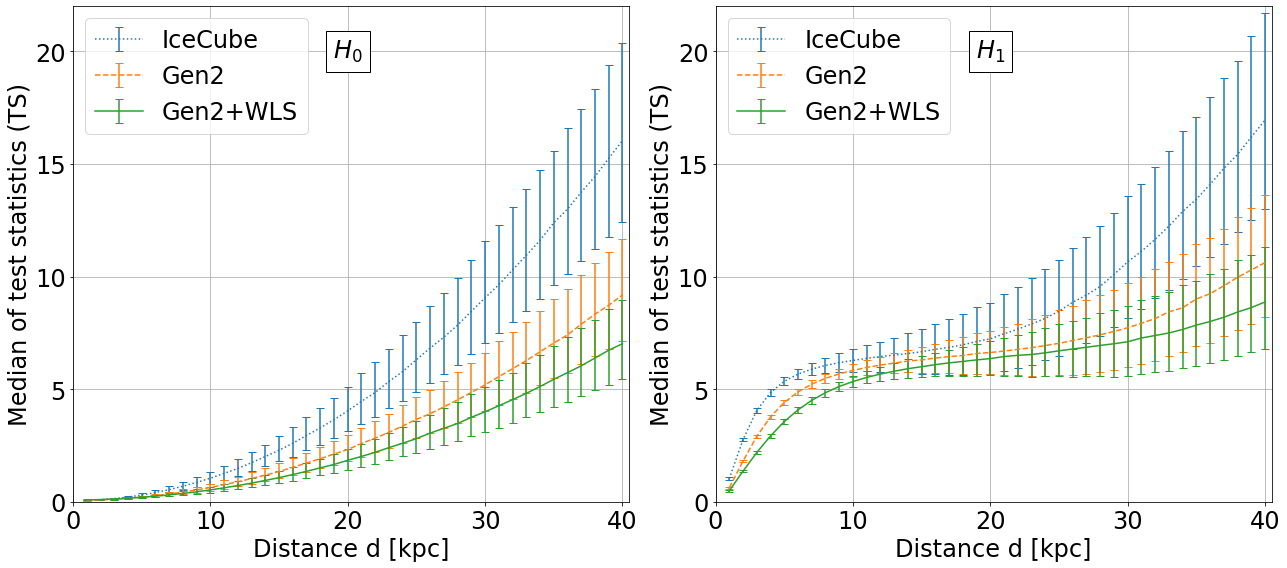

In [7]:
fig, ax = plt.subplots(1,2, figsize = (18,8))

#background with errorbar
ax[0].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label='IceCube')
ax[0].errorbar(x=distances1, y=Bts1_gen2.T[0],yerr=(Bts1_gen2.T[0]-Bts1_gen2.T[1],Bts1_gen2.T[2]-Bts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = '--', label='Gen2')
ax[0].errorbar(x=distances2, y=Bts2_gen2.T[0],yerr=(Bts2_gen2.T[0]-Bts2_gen2.T[1],Bts2_gen2.T[2]-Bts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = '-', label='Gen2+WLS')
ax[0].text(20, 20, r"$H_0$", size=24,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)


#signal without errorbar

ax[1].errorbar(x=distances1, y=Sts1_ic86.T[0],yerr=(Sts1_ic86.T[0]-Sts1_ic86.T[1],Sts1_ic86.T[2]-Sts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label='IceCube')
ax[1].errorbar(x=distances1, y=Sts1_gen2.T[0],yerr=(Sts1_gen2.T[0]-Sts1_gen2.T[1],Sts1_gen2.T[2]-Sts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = '--', label='Gen2')
ax[1].errorbar(x=distances2, y=Sts2_gen2.T[0],yerr=(Sts2_gen2.T[0]-Sts2_gen2.T[1],Sts2_gen2.T[2]-Sts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = '-', label='Gen2+WLS')
ax[1].text(20, 20, r"$H_1$", size=24,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)

for i in range(2):
    ax[i].set_xlabel('Distance d [kpc]', fontsize = 24)
    ax[i].set_ylabel('Median of test statistics (TS)', fontsize = 24)
    ax[i].set_xlim((0,40.5))
    ax[i].set_ylim((0,22))
    ax[i].set_yticks([0,5,10,15,20])

    #ax[i].set_yscale('log')
    ax[i].tick_params(labelsize = 24)
    ax[i].legend(fontsize = 24, loc = 'upper left')
    ax[i].grid()
plt.tight_layout()
plt.savefig('../plots/ftf_temp_tsdistance.pdf', dpi = 200, facecolor = 'white')

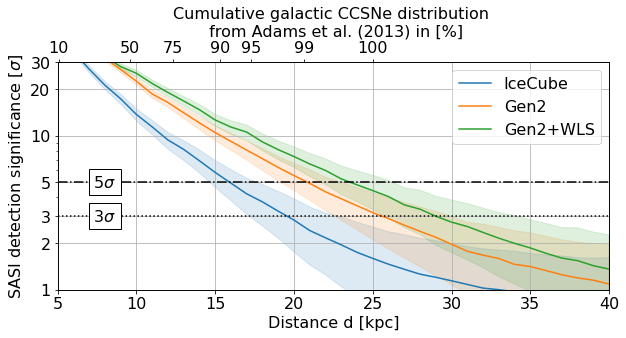

In [11]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
font = {'size'   : 50}

mpl.rc('font', **font)

ax.plot(distances1, Z1_ic86.T[0], color = 'C0', label=r'IceCube')
ax.plot(distances1, Z1_gen2.T[0], color = 'C1', label=r'Gen2')
ax.plot(distances1, Z2_gen2.T[0], color = 'C2', label=r'Gen2+WLS')

ax.fill_between(distances1.value, Z1_ic86.T[2], Z1_ic86.T[1], alpha = 0.15, color = 'C0')
ax.fill_between(distances1.value, Z1_gen2.T[2], Z1_gen2.T[1], alpha = 0.15, color = 'C1')
ax.fill_between(distances1.value, Z2_gen2.T[2], Z2_gen2.T[1], alpha = 0.15, color = 'C2')

ax.set_xlabel('Distance d [kpc]', fontsize = 16)
ax.set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 16)
ax.set_xlim((5,40))
ax.set_ylim((1,30))

ax.tick_params(labelsize = 16)

ax.set_xticks([5,10,15,20,25,30,35,40])

ax.set_yscale('log')
ax.set_yticks([1,2,3,5,10,20,30])
ax.set_yticklabels(['1','2','3','5','10','20','30'])

ax.grid()
ax.legend(loc='upper right', fontsize = 16)

ax.axhline(3, color='k', ls = ':')
ax.axhline(5, color='k', ls = '-.')
ax.text(8, 3, r"3$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax.text(8, 5, r"5$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax.twiny()
ax22.set_xlim(ax.get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 16)

plt.tight_layout()
plt.savefig('../plots/ftf_temp_results.pdf', dpi = 200, facecolor = 'white')

In [ ]:
vanilla_ic86 = np.array([[19.6,2.4,3.4],[15.9,1.3,1.8]])
vanilla_gen2 = np.array([[25.6,3.0,4.4],[20.8,1.7,2.1]])
vanilla_wls = np.array([[29.0,3.2,5.2],[23.5,1.8,2.7]])

timewid_ic86 = np.array([[20.6,2.6,4.2],[16.4,1.4,1.9]])
timewid_gen2 = np.array([[27.1,3.2,5.4],[21.5,1.8,2.6]])
timewid_wls = np.array([[30.8,4.0,6.4],[24.5,2.3,2.6]])

freqplus_ic86 = np.array([[13.5,1.6,2.5],[10.6,1.0,1.2]])
freqplus_gen2 = np.array([[17.4,2.0,3.0],[13.8,1.2,1.4]])
freqplus_wls = np.array([[19.6,2.3,3.5],[15.2,1.2,1.9]])

freqminus_ic86 = np.array([[12.6,1.4,2.5],[9.9,0.9,1.3]])
freqminus_gen2 = np.array([[16.5,1.9,3.1],[12.9,1.2,1.5]])
freqminus_wls = np.array([[18.5,2.2,3.9],[14.2,1.2,2.0]])

perhalf_ic86 = np.array([[17.9,2.0,2.7],[14.6,1.1,1.6]])
perhalf_gen2 = np.array([[23.3,2.4,3.6],[19.1,1.4,2.0]])
perhalf_wls = np.array([[26.3,2.6,4.5],[21.5,1.6,2.2]])

perdoub_ic86 = np.array([[17.9,2.4,3.7],[14.0,1.2,1.8]])
perdoub_gen2 = np.array([[23.4,2.8,5.0],[18.3,1.6,2.4]])
perdoub_wls = np.array([[26.8,3.5,5.3],[20.8,1.9,2.5]])

compex_ic86 = np.array([[13.2,1.6,2.5],[10.7,0.9,1.4]])
compex_gen2 = np.array([[17.3,2.2,3.3],[14.2,1.4,1.4]])
compex_wls = np.array([[19.6,2.5,3.9],[15.8,1.5,1.9]])

mswnh_ic86 = np.array([[17.8,2.2,3.2],[14.5,1.2,1.6]])
mswnh_gen2 = np.array([[23.3,2.8,3.9],[19.1,1.6,1.9]])
mswnh_wls = np.array([[26.4,3.0,4.8],[21.4,1.8,2.4]])

mswih_ic86 = np.array([[13.4,1.7,2.6],[10.9,1.0,1.3]])
mswih_gen2 = np.array([[17.5,2.2,3.3],[14.3,1.4,1.5]])
mswih_wls = np.array([[19.8,2.5,4.0],[16.0,1.5,1.7]])

m27d1_ic86 = np.array([[12.4,1.6,2.1],[9.9,0.9,1.0]])
m27d1_gen2 = np.array([[16.1,1.9,3.0],[12.9,1.1,1.3]])
m27d1_wls = np.array([[18.1,2.1,3.4],[14.3,1.3,1.7]])

m27d2_ic86 = np.array([[5.5,1.0,1.5],[4.1,0.8,0.8]])
m27d2_gen2 = np.array([[6.7,1.2,1.8],[4.8,1.0,1.0]])
m27d2_wls = np.array([[6.9,1.8,2.2],[3.9,2.7,3.9]])

m27d3_ic86 = np.array([[5.2,0.9,1.4], [3.7,0.8,0.8]])
m27d3_gen2 = np.array([[6.2,1.1,1.5], [4.0,4.0,1.2]])
m27d3_wls = np.array([[6.0,2.0,2.1], [0.0,0.0,4.0]])

In [ ]:
mpl.rcParams['legend.handlelength'] = 0
mpl.rcParams['legend.markerscale'] = 1

fig, ax = plt.subplots(1,1, figsize = (10,6))
xlabels = ['75 ms < $t$ < 338 ms\nNo Transformation\n$27 M_{\odot}$', r'150 ms < $t$ < 300 ms', '$f_{temp}$ + 10 Hz', 
           '$f_{temp}$ - 10 Hz', r'$n_{period} \times 1/2$', r'$n_{period} \times 2$',
           'Complete\nExchange', 'Adiabatic\nMSW NH', 'Adiabatic\nMSW IH', 
           r'$27 M_{\odot}, d_1$', r'$27 M_{\odot}, d_2$', r'$27 M_{\odot}, d_3$']

ax.errorbar(x=-0.1, y=vanilla_ic86[0][0], yerr=vanilla_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=0, y=vanilla_gen2[0][0], yerr=vanilla_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=0.1, y=vanilla_wls[0][0], yerr=vanilla_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(0.5, color = 'grey', ls = '--')

ax.errorbar(x=0.9, y=timewid_ic86[0][0], yerr=timewid_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=1, y=timewid_gen2[0][0], yerr=timewid_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=1.1, y=timewid_wls[0][0], yerr=timewid_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=1.9, y=freqplus_ic86[0][0], yerr=freqplus_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=2, y=freqplus_gen2[0][0], yerr=freqplus_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=2.1, y=freqplus_wls[0][0], yerr=freqplus_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=2.9, y=freqminus_ic86[0][0], yerr=freqminus_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=3, y=freqminus_gen2[0][0], yerr=freqminus_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=3.1, y=freqminus_wls[0][0], yerr=freqminus_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=3.9, y=perhalf_ic86[0][0], yerr=perhalf_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=4, y=perhalf_gen2[0][0], yerr=perhalf_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=4.1, y=perhalf_wls[0][0], yerr=perhalf_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=4.9, y=perdoub_ic86[0][0], yerr=perdoub_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=5, y=perdoub_gen2[0][0], yerr=perdoub_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=5.1, y=perdoub_wls[0][0], yerr=perdoub_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')


ax.axvline(5.5, color = 'grey', ls = '--')

ax.errorbar(x=5.9, y=compex_ic86[0][0], yerr=compex_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=6, y=compex_gen2[0][0], yerr=compex_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=6.1, y=compex_wls[0][0], yerr=compex_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=6.9, y=mswnh_ic86[0][0], yerr=mswnh_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=7, y=mswnh_gen2[0][0], yerr=mswnh_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=7.1, y=mswnh_wls[0][0], yerr=mswnh_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=7.9, y=mswih_ic86[0][0], yerr=mswih_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=8, y=mswih_gen2[0][0], yerr=mswih_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=8.1, y=mswih_wls[0][0], yerr=mswih_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(8.5, color = 'grey', ls = '--')

ax.errorbar(x=8.9, y=m27d1_ic86[0][0], yerr=m27d1_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=9, y=m27d1_gen2[0][0], yerr=m27d1_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=9.1, y=m27d1_wls[0][0], yerr=m27d1_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=9.9, y=m27d2_ic86[0][0], yerr=m27d2_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=10, y=m27d2_gen2[0][0], yerr=m27d2_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=10.1, y=m27d2_wls[0][0], yerr=m27d2_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=10.9, y=m27d3_ic86[0][0], yerr=m27d3_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=11, y=m27d3_gen2[0][0], yerr=m27d3_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=11.1, y=m27d3_wls[0][0], yerr=m27d3_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=-1, y=vanilla_ic86[0][0], yerr=vanilla_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax.errorbar(x=-1, y=vanilla_gen2[0][0], yerr=vanilla_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax.errorbar(x=-1, y=vanilla_wls[0][0], yerr=vanilla_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax.tick_params(labelsize = 14)
ax.grid(axis='y')
ax.set_xticks(np.arange(12), labels = xlabels, rotation = 70, fontsize = 14)
ax.set_xlim(-0.5,11.5)
ax.set_ylim(0,40)
ax.set_ylabel(r'$3\sigma$ Significance Horizon [kpc]', fontsize=14)
ax.legend(loc = 'upper right', fontsize=14)

rates = np.array([0.2,0.5,0.75,0.95,0.99,1])
ax22 = ax.twinx()
ax22.set_ylim(ax.get_ylim())
ax22.set_yticks(inv_cdf(rates).flatten())
ax22.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 14)
ax22.set_ylabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 14)

ax.annotate('Default', xy=(0.04, 1.1), xytext=(0.04, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Analysis Cuts', xy=(0.29, 1.1), xytext=(0.29, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=8.5, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Flavour Mixing', xy=(0.625, 1.1), xytext=(0.625, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('SN Model', xy=(0.875, 1.1), xytext=(0.875, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))

plt.tight_layout()
plt.savefig('../plots/ftf_temp_all_3sigma.pdf', dpi = 200)

In [ ]:
mpl.rcParams['legend.handlelength'] = 0
mpl.rcParams['legend.markerscale'] = 1

fig, ax = plt.subplots(1,1, figsize = (10,6))
xlabels = ['75 ms < $t$ < 338 ms\nNo Transformation\n$27 M_{\odot}$', r'150 ms < $t$ < 300 ms', '$f_{temp}$ + 10 Hz', 
           '$f_{temp}$ - 10 Hz', r'$n_{period} \times 1/2$', r'$n_{period} \times 2$',
           'Complete\nExchange', 'Adiabatic\nMSW NH', 'Adiabatic\nMSW IH', 
           r'$27 M_{\odot}, d_1$', r'$27 M_{\odot}, d_2$', r'$27 M_{\odot}, d_3$']

ax.errorbar(x=-0.1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=0, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=0.1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(0.5, color = 'grey', ls = '--')

ax.errorbar(x=0.9, y=timewid_ic86[1][0], yerr=timewid_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=1, y=timewid_gen2[1][0], yerr=timewid_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=1.1, y=timewid_wls[1][0], yerr=timewid_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=1.9, y=freqplus_ic86[1][0], yerr=freqplus_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=2, y=freqplus_gen2[1][0], yerr=freqplus_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=2.1, y=freqplus_wls[1][0], yerr=freqplus_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=2.9, y=freqminus_ic86[1][0], yerr=freqminus_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=3, y=freqminus_gen2[1][0], yerr=freqminus_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=3.1, y=freqminus_wls[1][0], yerr=freqminus_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=3.9, y=perhalf_ic86[1][0], yerr=perhalf_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=4, y=perhalf_gen2[1][0], yerr=perhalf_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=4.1, y=perhalf_wls[1][0], yerr=perhalf_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=4.9, y=perdoub_ic86[1][0], yerr=perdoub_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=5, y=perdoub_gen2[1][0], yerr=perdoub_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=5.1, y=perdoub_wls[1][0], yerr=perdoub_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(5.5, color = 'grey', ls = '--')

ax.errorbar(x=5.9, y=compex_ic86[1][0], yerr=compex_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=6, y=compex_gen2[1][0], yerr=compex_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=6.1, y=compex_wls[1][0], yerr=compex_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=6.9, y=mswnh_ic86[1][0], yerr=mswnh_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=7, y=mswnh_gen2[1][0], yerr=mswnh_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=7.1, y=mswnh_wls[1][0], yerr=mswnh_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=7.9, y=mswih_ic86[1][0], yerr=mswih_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=8, y=mswih_gen2[1][0], yerr=mswih_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=8.1, y=mswih_wls[1][0], yerr=mswih_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(8.5, color = 'grey', ls = '--')

ax.errorbar(x=8.9, y=m27d1_ic86[1][0], yerr=m27d1_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=9, y=m27d1_gen2[1][0], yerr=m27d1_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=9.1, y=m27d1_wls[1][0], yerr=m27d1_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=9.9, y=m27d2_ic86[1][0], yerr=m27d2_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=10, y=m27d2_gen2[1][0], yerr=m27d2_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=10.1, y=m27d2_wls[1][0], yerr=m27d2_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=10.9, y=m27d3_ic86[1][0], yerr=m27d3_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=11, y=m27d3_gen2[1][0], yerr=m27d3_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=11.1, y=m27d3_wls[1][0], yerr=m27d3_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=-1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax.errorbar(x=-1, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax.errorbar(x=-1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax.tick_params(labelsize = 14)
ax.grid(axis='y')
ax.set_xticks(np.arange(12), labels = xlabels, rotation = 70, fontsize = 14)
ax.set_xlim(-0.5,11.5)
ax.set_ylim(0,40)

ax.set_ylabel(r'$5\sigma$ Significance Horizon [kpc]', fontsize=14)
ax.legend(loc = 'upper right', fontsize=14)

rates = np.array([0.2,0.5,0.75,0.95,0.99,1])
ax22 = ax.twinx()
ax22.set_ylim(ax.get_ylim())
ax22.set_yticks(inv_cdf(rates).flatten())
ax22.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 14)
ax22.set_ylabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 14)


ax.annotate('Default', xy=(0.04, 1.1), xytext=(0.04, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Analysis Cuts', xy=(0.29, 1.1), xytext=(0.29, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=8.5, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Flavour Mixing', xy=(0.625, 1.1), xytext=(0.625, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('SN Model', xy=(0.875, 1.1), xytext=(0.875, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))


plt.tight_layout()
plt.savefig('../plots/ftf_temp_all_5sigma.pdf', dpi = 200)

In [ ]:
mpl.rcParams['legend.handlelength'] = 0
mpl.rcParams['legend.markerscale'] = 1

fig, ax = plt.subplots(2,1, figsize = (12,12), sharex = True)
xlabels = ['75 ms < $t$ < 338 ms\nNo Transformation\n$27 M_{\odot}$', r'150 ms < $t$ < 300 ms', '$f_{temp}$ + 10 Hz', 
           '$f_{temp}$ - 10 Hz', r'$n_{period} \times 1/2$', r'$n_{period} \times 2$',
           'Complete\nExchange', 'Adiabatic\nMSW NH', 'Adiabatic\nMSW IH', 
           r'$27 M_{\odot}, d_1$', r'$27 M_{\odot}, d_2$', r'$27 M_{\odot}, d_3$']

for j in range(2):
    ax[j].errorbar(x=-0.1, y=vanilla_ic86[j][0], yerr=vanilla_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=0, y=vanilla_gen2[j][0], yerr=vanilla_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=0.1, y=vanilla_wls[j][0], yerr=vanilla_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].axvline(0.5, color = 'grey', ls = '--')

    ax[j].errorbar(x=0.9, y=timewid_ic86[j][0], yerr=timewid_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=1, y=timewid_gen2[j][0], yerr=timewid_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=1.1, y=timewid_wls[j][0], yerr=timewid_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].errorbar(x=1.9, y=freqplus_ic86[j][0], yerr=freqplus_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=2, y=freqplus_gen2[j][0], yerr=freqplus_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=2.1, y=freqplus_wls[j][0], yerr=freqplus_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].errorbar(x=2.9, y=freqminus_ic86[j][0], yerr=freqminus_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=3, y=freqminus_gen2[j][0], yerr=freqminus_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=3.1, y=freqminus_wls[j][0], yerr=freqminus_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].errorbar(x=3.9, y=perhalf_ic86[j][0], yerr=perhalf_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=4, y=perhalf_gen2[j][0], yerr=perhalf_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=4.1, y=perhalf_wls[j][0], yerr=perhalf_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].errorbar(x=4.9, y=perdoub_ic86[j][0], yerr=perdoub_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=5, y=perdoub_gen2[j][0], yerr=perdoub_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=5.1, y=perdoub_wls[j][0], yerr=perdoub_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].axvline(5.5, color = 'grey', ls = '--')

    ax[j].errorbar(x=5.9, y=compex_ic86[j][0], yerr=compex_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=6, y=compex_gen2[j][0], yerr=compex_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=6.1, y=compex_wls[j][0], yerr=compex_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].errorbar(x=6.9, y=mswnh_ic86[j][0], yerr=mswnh_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=7, y=mswnh_gen2[j][0], yerr=mswnh_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=7.1, y=mswnh_wls[j][0], yerr=mswnh_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].errorbar(x=7.9, y=mswih_ic86[j][0], yerr=mswih_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=8, y=mswih_gen2[j][0], yerr=mswih_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=8.1, y=mswih_wls[j][0], yerr=mswih_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].axvline(8.5, color = 'grey', ls = '--')

    ax[j].errorbar(x=8.9, y=m27d1_ic86[j][0], yerr=m27d1_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=9, y=m27d1_gen2[j][0], yerr=m27d1_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=9.1, y=m27d1_wls[j][0], yerr=m27d1_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].errorbar(x=9.9, y=m27d2_ic86[j][0], yerr=m27d2_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=10, y=m27d2_gen2[j][0], yerr=m27d2_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=10.1, y=m27d2_wls[j][0], yerr=m27d2_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].errorbar(x=10.9, y=m27d3_ic86[j][0], yerr=m27d3_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
    ax[j].errorbar(x=11, y=m27d3_gen2[j][0], yerr=m27d3_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
    ax[j].errorbar(x=11.1, y=m27d3_wls[j][0], yerr=m27d3_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

    ax[j].errorbar(x=-1, y=vanilla_ic86[j][0], yerr=vanilla_ic86[j][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
    ax[j].errorbar(x=-1, y=vanilla_gen2[j][0], yerr=vanilla_gen2[j][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
    ax[j].errorbar(x=-1, y=vanilla_wls[j][0], yerr=vanilla_wls[j][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


    ax[j].tick_params(labelsize = 16)
    ax[j].grid(axis='y')
    ax[j].set_xlim(-0.5,11.5)
    ax[j].set_ylim(0,40)
    ax[j].legend(loc = 'upper right', fontsize=16)

ax[1].set_xticks(np.arange(12), labels = xlabels, rotation = 70, fontsize = 16)    
ax[0].set_ylabel(r'$3\sigma$ Significance Horizon [kpc]', fontsize=16)
ax[1].set_ylabel(r'$5\sigma$ Significance Horizon [kpc]', fontsize=16)

rates = np.array([0.2,0.4,0.6,0.8,0.9,0.95,0.99,1])
ax21 = ax[0].twinx()
ax21.set_ylim(ax[0].get_ylim())
ax21.set_yticks(inv_cdf(rates).flatten())
ax21.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax21.set_ylabel('Cumulative Galactic \n CCSNe Distribution [%]', fontsize = 16)

ax[0].annotate('Default', xy=(0.04, 1.05), xytext=(0.04, 1.1), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.5', lw=1.0, color='k'))

ax[0].annotate('Analysis Cuts', xy=(0.29, 1.05), xytext=(0.29, 1.1), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=10, lengthB=0.5', lw=1.0, color='k'))

ax[0].annotate('Flavour Mixing', xy=(0.625, 1.05), xytext=(0.625, 1.1), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.5', lw=1.0, color='k'))

ax[0].annotate('SN Model', xy=(0.875, 1.05), xytext=(0.875, 1.1), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.5', lw=1.0, color='k'))

"""
ax[1].errorbar(x=-0.1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=0, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=0.1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].axvline(0.5, color = 'grey', ls = '--')


ax[1].errorbar(x=0.9, y=timewid_ic86[1][0], yerr=timewid_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=1, y=timewid_gen2[1][0], yerr=timewid_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=1.1, y=timewid_wls[1][0], yerr=timewid_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=1.9, y=freqplus_ic86[1][0], yerr=freqplus_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=2, y=freqplus_gen2[1][0], yerr=freqplus_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=2.1, y=freqplus_wls[1][0], yerr=freqplus_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=2.9, y=freqminus_ic86[1][0], yerr=freqminus_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=3, y=freqminus_gen2[1][0], yerr=freqminus_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=3.1, y=freqminus_wls[1][0], yerr=freqminus_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=3.9, y=perhalf_ic86[1][0], yerr=perhalf_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=4, y=perhalf_gen2[1][0], yerr=perhalf_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=4.1, y=perhalf_wls[1][0], yerr=perhalf_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=4.9, y=perdoub_ic86[1][0], yerr=perdoub_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=5, y=perdoub_gen2[1][0], yerr=perdoub_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=5.1, y=perdoub_wls[1][0], yerr=perdoub_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].axvline(5.5, color = 'grey', ls = '--')

ax[1].errorbar(x=5.9, y=compex_ic86[1][0], yerr=compex_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=6, y=compex_gen2[1][0], yerr=compex_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=6.1, y=compex_wls[1][0], yerr=compex_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=6.9, y=mswnh_ic86[1][0], yerr=mswnh_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=7, y=mswnh_gen2[1][0], yerr=mswnh_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=7.1, y=mswnh_wls[1][0], yerr=mswnh_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=7.9, y=mswih_ic86[1][0], yerr=mswih_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=8, y=mswih_gen2[1][0], yerr=mswih_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=8.1, y=mswih_wls[1][0], yerr=mswih_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].axvline(8.5, color = 'grey', ls = '--')

ax[1].errorbar(x=8.9, y=m27d1_ic86[1][0], yerr=m27d1_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=9, y=m27d1_gen2[1][0], yerr=m27d1_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=9.1, y=m27d1_wls[1][0], yerr=m27d1_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=9.9, y=m27d2_ic86[1][0], yerr=m27d2_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=10, y=m27d2_gen2[1][0], yerr=m27d2_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=10.1, y=m27d2_wls[1][0], yerr=m27d2_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=10.9, y=m27d3_ic86[1][0], yerr=m27d3_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=11, y=m27d3_gen2[1][0], yerr=m27d3_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=11.1, y=m27d3_wls[1][0], yerr=m27d3_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=-1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax[1].errorbar(x=-1, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax[1].errorbar(x=-1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax[1].tick_params(labelsize = 16)
ax[1].grid(axis='y')
ax[1].set_xticks(np.arange(12), labels = xlabels, rotation = 70, fontsize = 16)
ax[1].set_xlim(-0.5,11.5)
ax[1].set_ylim(0,40)

ax[1].set_ylabel(r'$5\sigma$ Significance Horizon [kpc]', fontsize=16)
ax[1].legend(loc = 'upper right', fontsize=16)
"""
rates = np.array([0.2,0.4,0.6,0.8,0.9,0.95,0.99,1])
ax22 = ax[1].twinx()
ax22.set_ylim(ax[1].get_ylim())
ax22.set_yticks(inv_cdf(rates).flatten())
ax22.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax22.set_ylabel('Cumulative Galactic \n CCSNe Distribution [%]', fontsize = 16)

plt.tight_layout()
plt.savefig('../plots/ftf_temp_all_3+5sigma.pdf', dpi = 200)